# Exploratory Data Analysis, Data Preprocessing, and Feature Engineering
## Twitter Sentiment Analysis of Apple and Google Products

Seamus Walsh and Daniel Gieseke | July 15, 2023

Twitter among other social media platforms boasts an immense amount of consumer reviews, thoughts, critiques, and praises; with this project, we aim to build a Natural Language Processing (NLP) model that utilizes 'tweets' from Twitter to predict the general sentiment surrounding Apple and Google as well as their respective products.  This data was sourced from Twitter via data.world and includes tweets along with a respective, pre-determined emotion--either "positive", "negative", "no emotion", or unknown.  Our goal is to create a model that can read in one of these tweets and predict whether the tweet is "positive", "negative", or "no emotion".

This notebook is focused on the Exploratory Data Analysis (EDA), data preprocessing, and feature engineering required to create our NLP model.  Throughout this notebook we have provided context behind our code and some simple explanations of our visualizations.  To view our models for this project, please visit our other Jupyter Notebook.

Data Source: https://data.world/crowdflower/brands-and-product-emotions

## Importing our Libraries and Data
Below we import the Python libraries we need to perform some initial EDA, Cleaning, and Processing on our data, then import our raw CSV of tweets and respective emotions.

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
sns.set_style("darkgrid")
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielgieseke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')

## Initial EDA
Below we review a sample of our data, review columns for null values, and inspect the values within our "is there an emotion directed at.." column.

In [3]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


**Creating a Visualization of Breakdown of Tweets by "Emotion"**

In [5]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

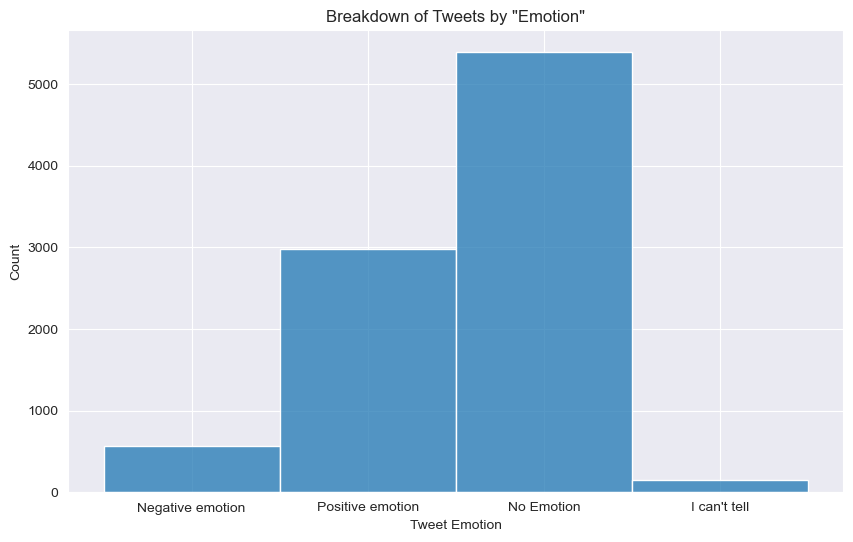

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
df2 = df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product": "Tweet Emotion"})
df2['Tweet Emotion'] = df2['Tweet Emotion'].replace('No emotion toward brand or product','No Emotion')
sns.histplot(df2['Tweet Emotion']).set(title='Breakdown of Tweets by "Emotion"');

**Analysis of Above Visualization:**
We can tell from the above visualization that our 'target' feature is highly variable.  We will take this into account when preparing our model by using 'SMOTE' to balance our target features.

**Creating a Visualization of Breakdown of Products Tweeted About**

In [7]:
df['emotion_in_tweet_is_directed_at'].value_counts()

emotion_in_tweet_is_directed_at
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

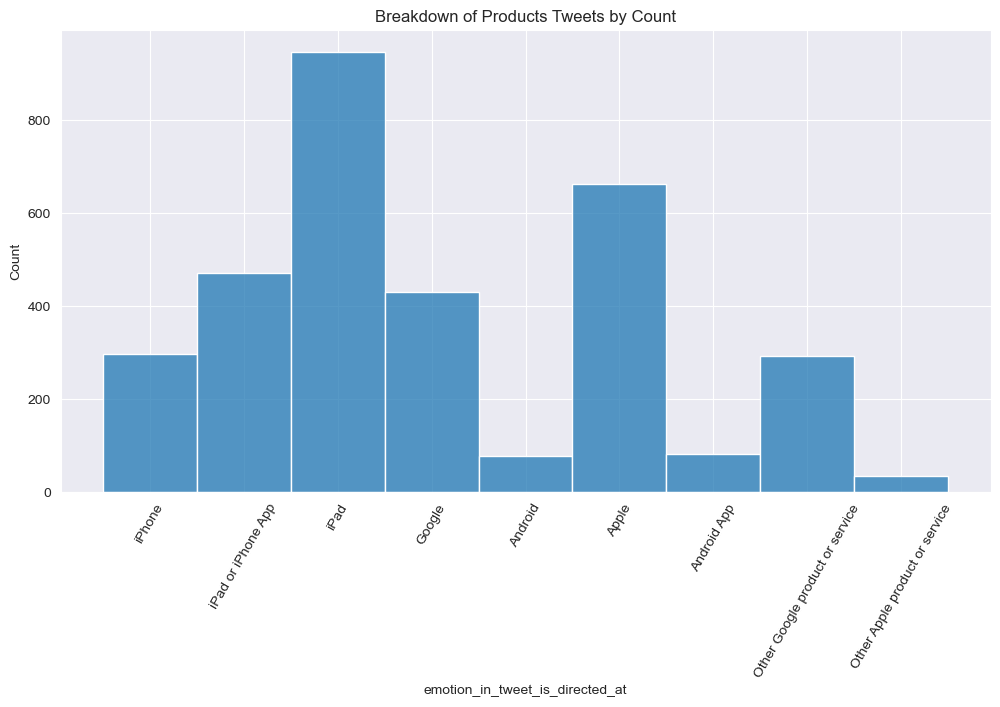

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(df['emotion_in_tweet_is_directed_at']).set(title='Breakdown of Products Tweets by Count')
plt.xticks(rotation=60);

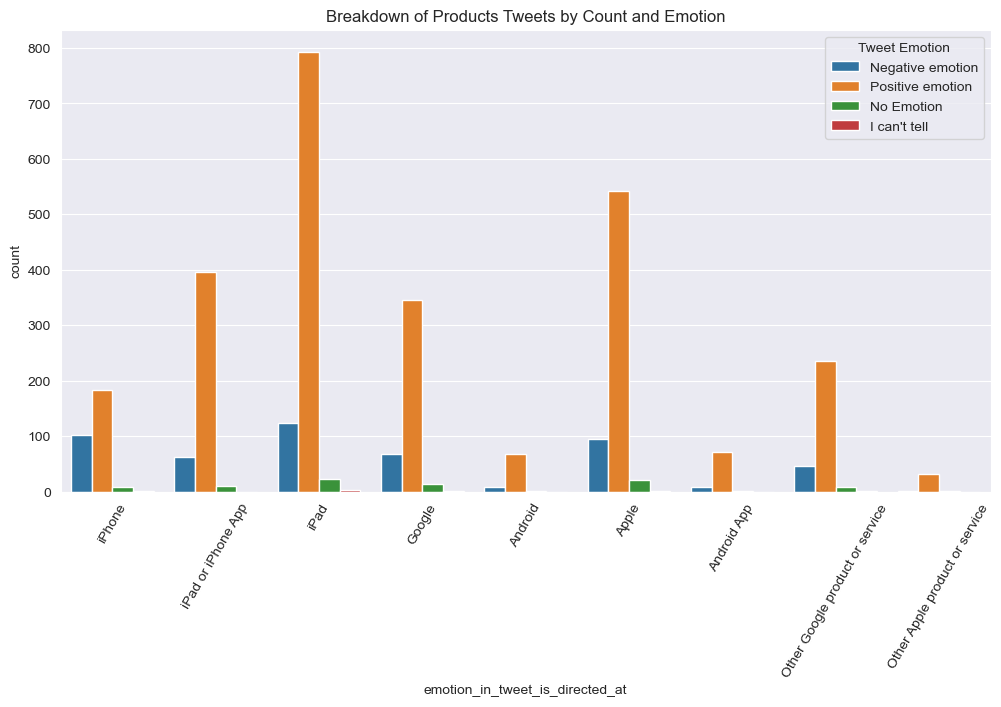

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x='emotion_in_tweet_is_directed_at', 
              data=df2, hue='Tweet Emotion').set(title='Breakdown of Products Tweets by Count and Emotion')
plt.xticks(rotation=60);

## Preprocessing Text Data for NLP
Below we are taking our text data from our tweets, tokenizing each word, removing stop words, stemming each word, then creating a new column.  This new column will be what our future model will vectorize.

In [10]:
# Creating an intance of the RegexpTokenizer
tokenizer = RegexpTokenizer(r"(?u)\w{3,}")

# Creating a list of stopwords in English
stopwords_list = stopwords.words('english')

# Creating an instance of nltk's PorterStemmer
stemmer = PorterStemmer()

In [11]:
def preprocess_text(text, tokenizer, stopwords_list, stemmer):
    # Standardize case (lowercase the text)
    text_lower = text.lower()
    # Tokenize text using `tokenizer`
    tokens = tokenizer.tokenize(text_lower)
    # Remove stopwords using `stopwords_list`
    tokens_cleaned = [word for word in tokens if word not in stopwords_list]
    # Stem the tokenized text using `stemmer`
    stemmed_tokens = [stemmer.stem(token) for token in tokens_cleaned]
    # Return the preprocessed text
    return stemmed_tokens

In [12]:
df.tweet_text = df.tweet_text.astype(str)

In [13]:
text_data = df.tweet_text.apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))

In [14]:
df['processed_text'] = text_data

## Creating a New DataFrame with Only Tweets Labeled as 'Positive', 'Negative', or 'No Emotion'
We are not interested in our tweets where contributors to our data were unsure of a tweet's emotion so we will only include tweets with the above-mentioned labels in our dataframe; luckily, this is almost all of our data.  We are concerned that the other ambiguous tweets will skew our model.

In [15]:
# Creating new df with positive, negative AND neutral tweets
df = df[(df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion') |
           (df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion') | 
           (df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'No emotion toward brand or product')] 

## Exploring Vocabulary between Positive and Negative Tweets
Now that we have a function for the pre-processing of our Tweet data, we go ahead and create a word clouds of the vocabulary used in positive vs negative tweets.  Unfortuantely for us, we see that a lot of the vocabulary is resused between both sets of Tweets, which we assume will make our model a bit harder to create.  Given this insight, we may opt for a "TF-IDF" vectorizer for our model, which takes the rareity of unique words into account.

In [16]:
# Creating DF of Negative Tweets
df_neg = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion']

# Processing the Data
neg_text_data = df_neg.tweet_text.apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))

# Creating Frequency Dictionary
neg_agg_list = []
for row in neg_text_data:
    neg_agg_list = neg_agg_list + row
    
neg_tweet_frequency_dict = {}
for word in neg_agg_list:
    if word not in neg_tweet_frequency_dict:
        neg_tweet_frequency_dict[word] = 1
    else:
        neg_tweet_frequency_dict[word] += 1

# Creating our WordCloud
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(neg_tweet_frequency_dict))

In [17]:
# Creating DF of Positive Tweets
df_pos = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion']

# Processing the Data
pos_text_data = df_pos.tweet_text.apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))

# Creating Frequency Dictionary
pos_agg_list = []
for row in pos_text_data:
    pos_agg_list = pos_agg_list + row
    
pos_tweet_frequency_dict = {}
for word in pos_agg_list:
    if word not in pos_tweet_frequency_dict:
        pos_tweet_frequency_dict[word] = 1
    else:
        pos_tweet_frequency_dict[word] += 1

# Creating our WordCloud
wordcloud2 = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(pos_tweet_frequency_dict))

In [ ]:
plt.figure(figsize=(12,8))

plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.imshow(wordcloud)
plt.title("WordCloud of Vocabulary from Negative Tweets", fontsize = 10)

plt.subplot(1, 2, 2) # index 2
plt.imshow(wordcloud2)
plt.title("WordCloud of Vocabulary from Positive Tweets", fontsize = 10)
plt.show()

## Feature Engineering
To boost the accuracy, we are going to create a few new features that we hope will aid our model.  Below we create new columns for identifying tweet 'Sentiment Score' and presence of frequent bigrams, and create dummies for our 'emotion_in_tweet_is_directed_at' column.

In [19]:
analyzer = SentimentIntensityAnalyzer()

sentiment_scores = []
for text in df['tweet_text']:
    scores = analyzer.polarity_scores(text)
    sentiment_scores.append(scores)
    
compound_scores = [score['compound'] for score in sentiment_scores]

df['sentiment_score'] = compound_scores

In [20]:
def extract_bigrams(tokens):
    bigram_finder = BigramCollocationFinder.from_words(tokens)
    bigrams = bigram_finder.nbest(BigramAssocMeasures.raw_freq, 10)  # Adjust the number as per your requirement
    return bigrams

df['bigrams'] = df['processed_text'].apply(extract_bigrams)

all_bigrams = []
for bigrams in df['bigrams']:
    all_bigrams.extend(bigrams)
bigram_freqdist = nltk.FreqDist(all_bigrams)

most_frequent_bigrams = [bigram for bigram, freq in bigram_freqdist.most_common(10)]

def check_bigrams(tokens):
    return int(any(bigram in most_frequent_bigrams for bigram in extract_bigrams(tokens)))

df['bigram_presence'] = df['processed_text'].apply(check_bigrams)

In [21]:
dummies = pd.get_dummies(df['emotion_in_tweet_is_directed_at'])
df = pd.concat([df, dummies], axis=1)

In [22]:
# Convert token lists to strings
df["joined_processed_text"] = df["processed_text"].str.join(" ")

# Dropping a 'NaN' value that was encoded as a string in our data
df = df.drop(6)

### Finally, we save our cleaned, processed, DataFrame with new features to a clean CSV file.

In [23]:
# Saving processed file to a new, clean csv
df.to_csv('cleaned_tweets.csv')